In [ ]:
!pip install gensim

In [ ]:
#Importing Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.metrics import accuracy_score
import torch.optim as optim
from torch._C import NoneType
import torch
import torch.nn.functional as F
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset
import time
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, log_loss, f1_score,precision_recall_fscore_support
import os
from sklearn.preprocessing import label_binarize
import h5py
from torchsummary import summary
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import math
import re
import spacy
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from torch.nn.utils.rnn import pad_sequence
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
cols = ['Class',"Title",'Article']
df_train = pd.read_csv('train.csv',names=cols)
df_test = pd.read_csv('test.csv',names=cols)

df_train['Text'] = df_train['Title'] + " " + df_train['Article']
df_test['Text'] = df_test['Title'] + " " + df_test['Article']

df= pd.concat([df_train[['Class', 'Text']], df_test[['Class', 'Text']]])
display(df)

,Class,Text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."
...,...,...
7595,1,Around the world Ukrainian presidential candid...
7596,2,Void is filled with Clement With the supply of...
7597,2,Martinez leaves bitter Like Roger Clemens did ...
7598,3,5 of arthritis patients in Singapore take Bext...


In [ ]:
#Statistics
df.describe()

,Class
count,127600.000000
mean,2.500000
std,1.118038
min,1.000000
25%,1.750000
50%,2.500000
75%,3.250000
max,4.000000


In [ ]:
#Handling null values - No Null values present
null_values_train = df["Text"].isnull().sum()
print(null_values_train)


0


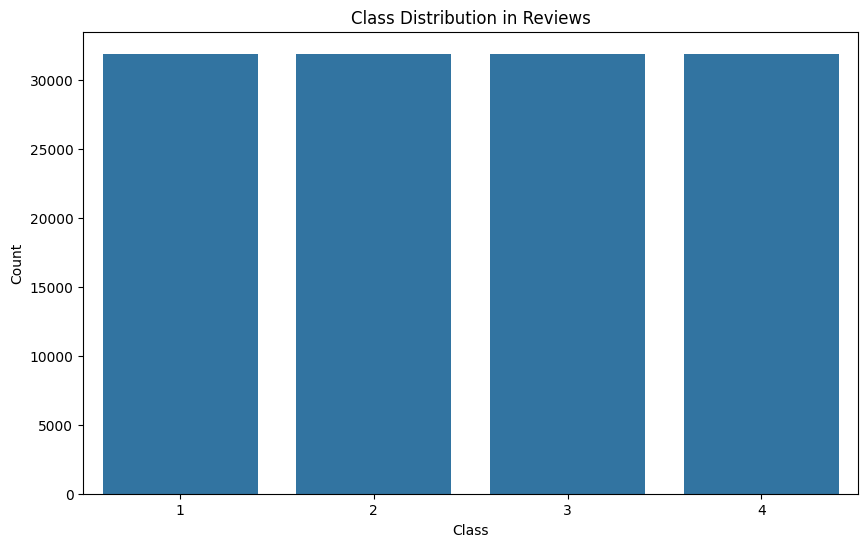

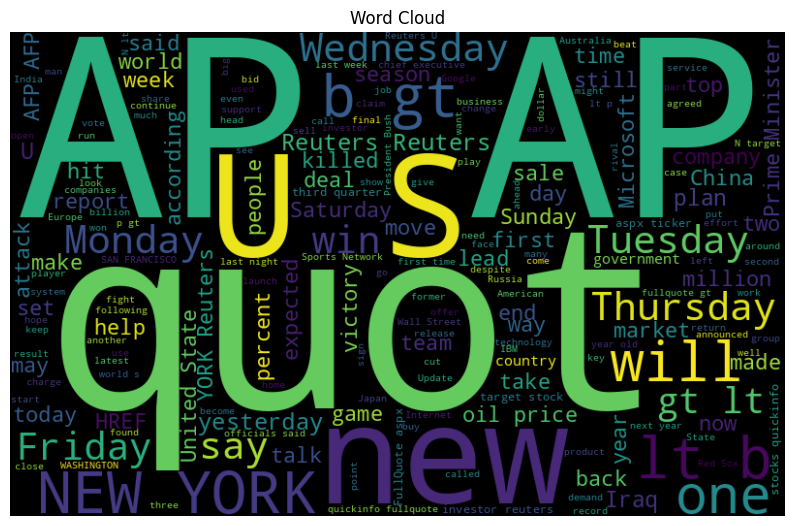

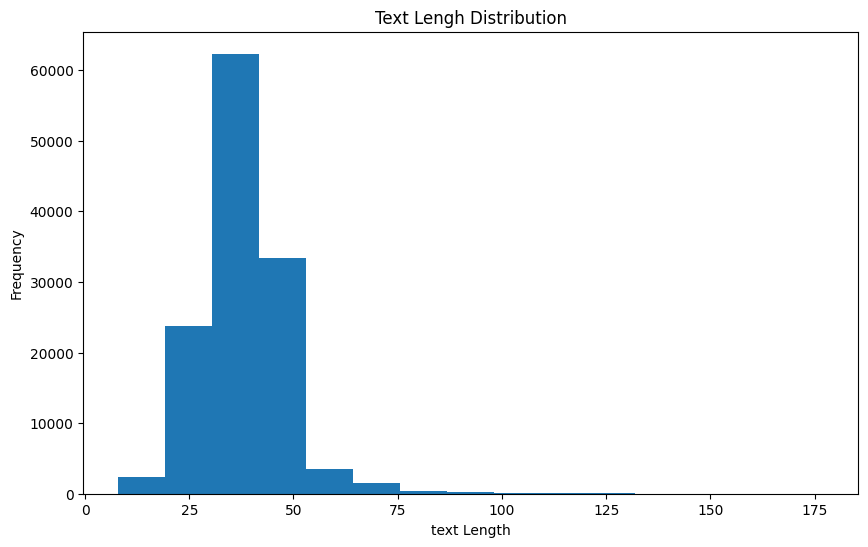

In [ ]:
#Plot1
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution in Reviews')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

#Plot2
full_text = ' '.join(df['Text'])
wordcloud = WordCloud(width=800, height=500).generate(full_text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis('off')
plt.show()

# PLot3
text_len = df['Text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(text_len, bins=15)
plt.title('Text Lengh Distribution')
plt.xlabel('text Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
train_val, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.125, random_state=42)

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def text_cleaning(text):
    text = text.lower().strip()
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalnum()]
    return filtered_tokens

train['Tokens'] = train['Text'].apply(text_cleaning)
val['Tokens'] = val['Text'].apply(text_cleaning)
test['Tokens'] = test['Text'].apply(text_cleaning)

tokens_all = [token for sublist in train['Tokens'] for token in sublist]
vocab = {word: i+1 for i, (word, _) in enumerate(Counter(tokens_all).most_common())}
vocab['<pad>'] = 0

def encode(tokens):
    return [vocab.get(token, 0) for token in tokens]

train['Encoded'] = train['Tokens'].apply(encode)
val['Encoded'] = val['Tokens'].apply(encode)
test['Encoded'] = test['Tokens'].apply(encode)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def data_lloaders(df, batch_size=64):
    sequences = [torch.tensor(s) for s in df['Encoded']]
    labels = torch.tensor(df['Class'].values - 1)
    data = list(zip(sequences, labels))

    def collate_fn(batch):
        texts, labels = zip(*batch)
        texts = pad_sequence(texts, batch_first=True, padding_value=vocab['<pad>'])
        labels = torch.tensor(labels)
        return texts, labels

    return DataLoader(data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# DataLoader creation
batch_size = 64
train_loader = data_lloaders(train, batch_size)
val_loader = data_lloaders(val, batch_size)
test_loader = data_lloaders(test, batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


transformer(
  (embedding): Embedding(56228, 256)
  (pos_encoder): positional_encoding()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_featur

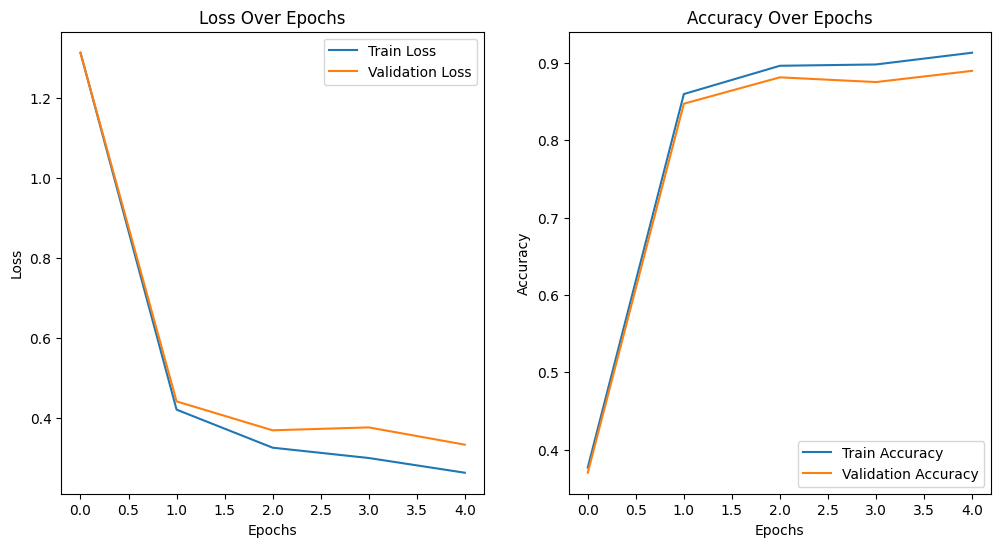

Test Loss: 0.3441, Test Accuracy: 0.8849


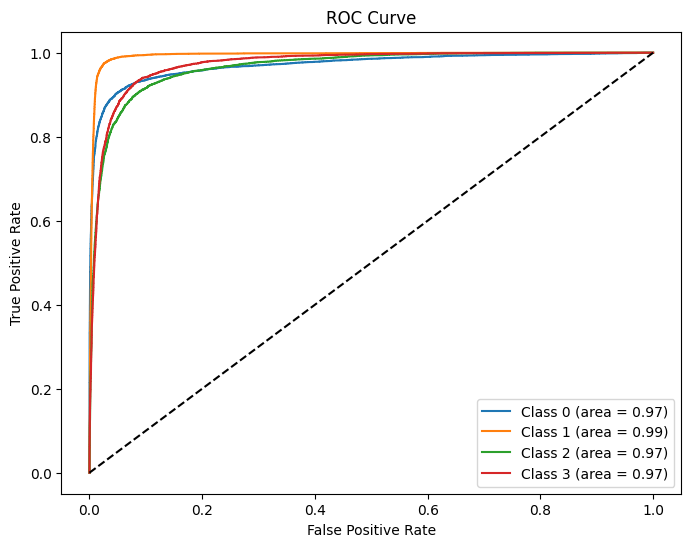

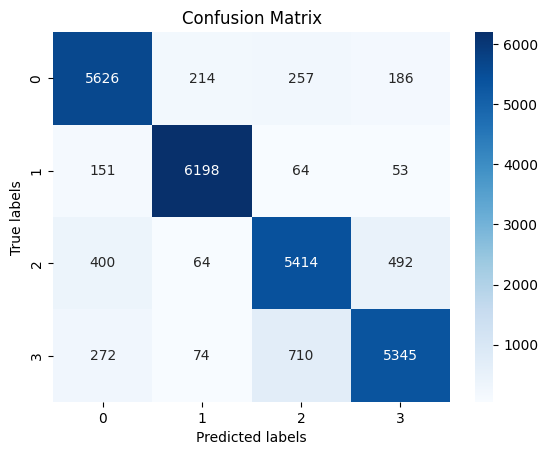

Precision: 0.8846, Recall: 0.8847, F1-Score: 0.8845


In [ ]:
#Base Model
class positional_encoding(nn.Module):
    def __init__(self, d_model, max_len=7000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class transformer(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super().__init__()
        self.embed_dim = 256
        self.embedding = nn.Embedding(vocab_size, self.embed_dim)
        self.pos_encoder = positional_encoding(self.embed_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.embed_dim, nhead=8, dim_feedforward=512)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=self.embed_dim, nhead=8, dim_feedforward=512)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=6)
        self.fc_out = nn.Linear(self.embed_dim, num_classes)

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.embed_dim)
        src = self.pos_encoder(src)
        memory = self.transformer_encoder(src)
        output = self.transformer_decoder(src, memory)
        output = output.mean(dim=1)
        output = self.fc_out(output)
        return output

model = transformer(vocab_size=len(vocab)+1, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

print(model)

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_losses, train_accuracies = [], []
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(texts)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        _, predicted = torch.max(output, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)
        train_accuracies.append(accuracy)
    avg_loss = sum(train_losses) / len(train_losses)
    avg_acc = sum(train_accuracies) / len(train_accuracies)
    return avg_loss, avg_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_count = 0, 0, 0
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            output = model(texts)
            loss = criterion(output, labels)
            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            probabilities = nn.functional.softmax(output, dim=1)
            total_correct += (predicted == labels).sum().item()
            total_count += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    avg_loss = total_loss / len(loader)
    avg_acc = total_correct / total_count
    return avg_loss, avg_acc, all_labels, all_preds, all_probs

def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_roc_curve(labels, scores, num_classes=4):
    labels = label_binarize(labels, classes=[0, 1, 2, 3])
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
epochs = 5
for epoch in range(epochs):
    model.train()
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(texts)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    train_loss, train_acc, _, _, _ = evaluate(model, train_loader, criterion, device)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)
test_loss, test_acc, test_labels, test_preds, test_probs = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

plot_roc_curve(test_labels, np.array(test_probs), num_classes=4)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1: Train Loss: 0.9345, Train Acc: 0.5765, Val Loss: 0.9433, Val Acc: 0.5694
Epoch 2: Train Loss: 0.4059, Train Acc: 0.8619, Val Loss: 0.4367, Val Acc: 0.8509
Epoch 3: Train Loss: 0.3329, Train Acc: 0.8892, Val Loss: 0.3741, Val Acc: 0.8756
Epoch 4: Train Loss: 0.2898, Train Acc: 0.9069, Val Loss: 0.3378, Val Acc: 0.8900
Epoch 5: Train Loss: 0.2722, Train Acc: 0.9111, Val Loss: 0.3301, Val Acc: 0.8918


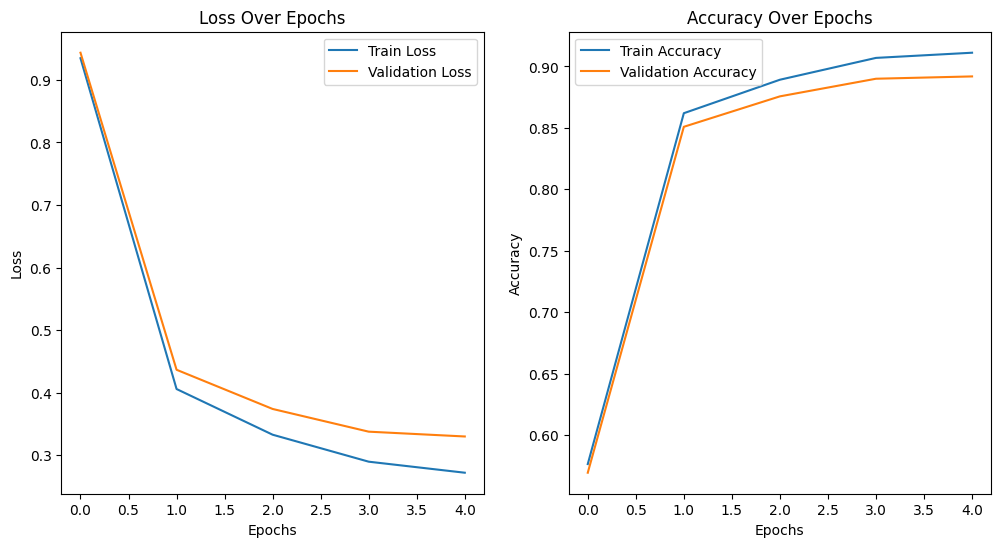

Test Loss: 0.3388, Test Accuracy: 0.8904


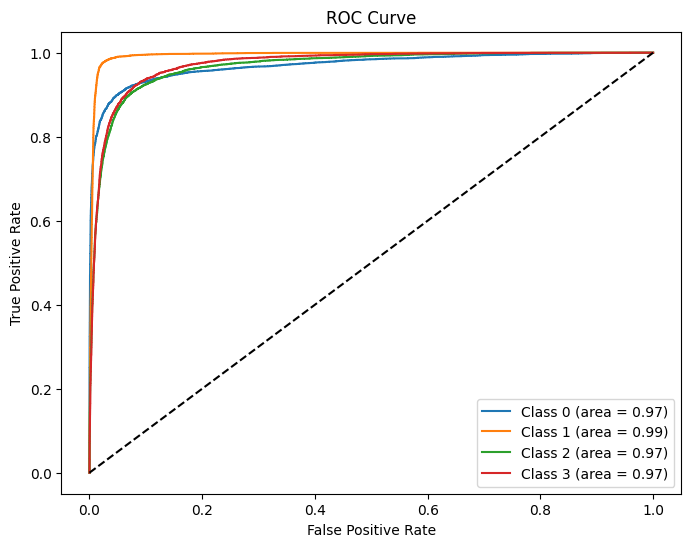

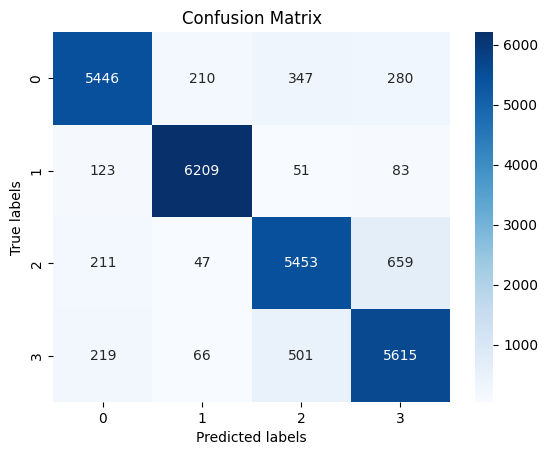

Precision: 0.8907, Recall: 0.8901, F1-Score: 0.8902


In [ ]:
#Dropout
class positional_encoding(nn.Module):
    def __init__(self, d_model, max_len=7000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class transformer2(nn.Module):
    def __init__(self, vocab_size, num_classes, dropout_rate=0.1):
        super().__init__()
        self.embed_dim = 256
        self.embedding = nn.Embedding(vocab_size, self.embed_dim)
        self.pos_encoder = positional_encoding(self.embed_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.embed_dim, nhead=8, dim_feedforward=512, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=self.embed_dim, nhead=8, dim_feedforward=512, dropout=dropout_rate)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=6)
        self.fc_out = nn.Linear(self.embed_dim, num_classes)

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.embed_dim)
        src = self.pos_encoder(src)
        src = self.dropout(src)
        memory = self.transformer_encoder(src)
        output = self.transformer_decoder(src, memory)
        output = output.mean(dim=1)
        output = self.fc_out(output)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = transformer2(vocab_size=len(vocab)+1, num_classes=4, dropout_rate=0.1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
epochs = 5
for epoch in range(epochs):
    model.train()
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(texts)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    train_loss, train_acc, _, _, _ = evaluate(model, train_loader, criterion, device)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)
test_loss, test_acc, test_labels, test_preds, test_probs = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

plot_roc_curve(test_labels, np.array(test_probs), num_classes=4)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1: Train Loss: 0.6039, Train Acc: 0.7724, Val Loss: 0.6269, Val Acc: 0.7611
Epoch 2: Train Loss: 0.3614, Train Acc: 0.8776, Val Loss: 0.4042, Val Acc: 0.8592
Epoch 3: Train Loss: 0.3039, Train Acc: 0.9018, Val Loss: 0.3609, Val Acc: 0.8800
Epoch 4: Train Loss: 0.2872, Train Acc: 0.9066, Val Loss: 0.3601, Val Acc: 0.8828
Epoch 5: Train Loss: 0.2625, Train Acc: 0.9137, Val Loss: 0.3444, Val Acc: 0.8813


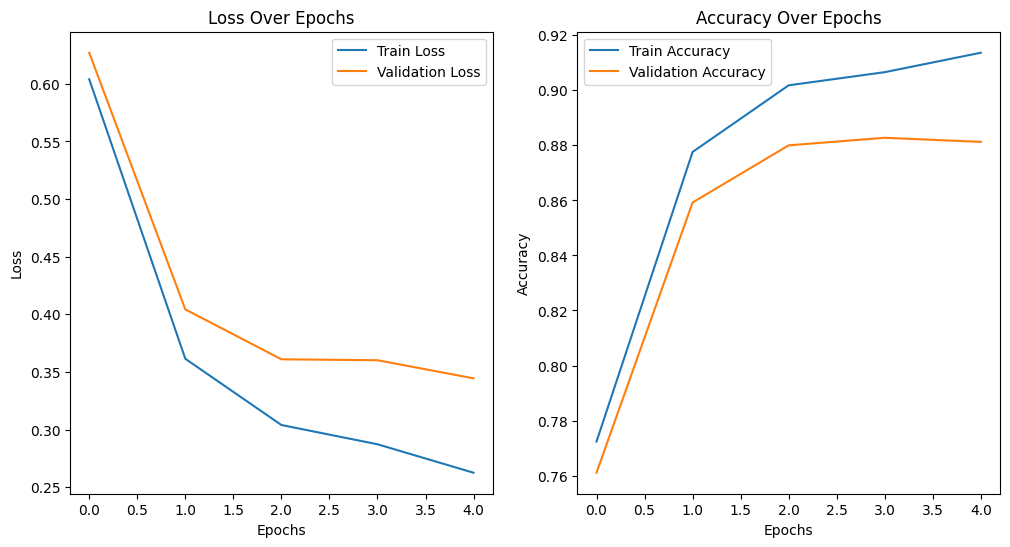

Final Test Loss: 0.3464, Test Accuracy: 0.8859


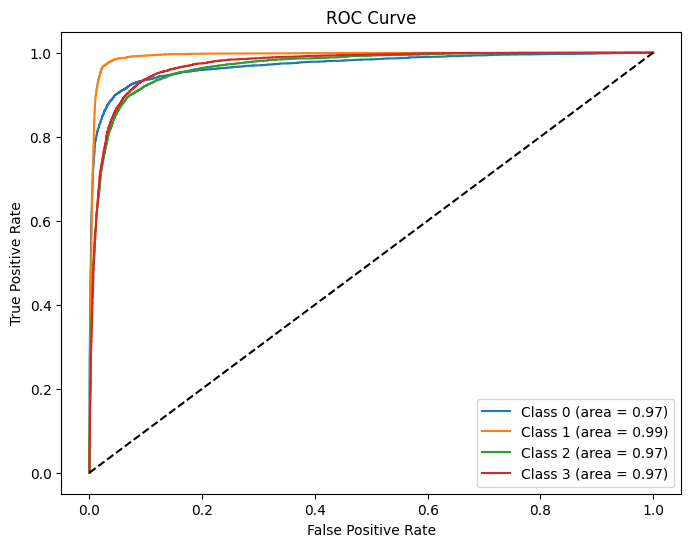

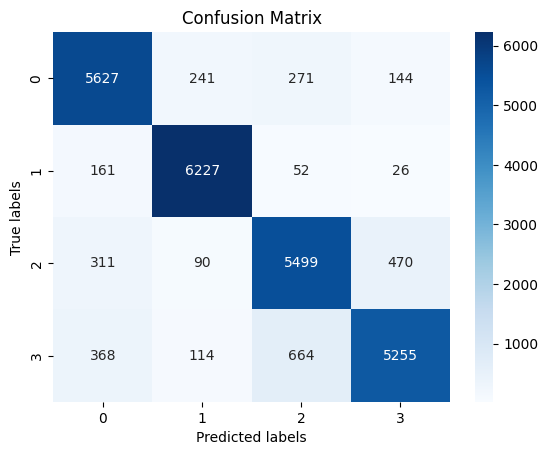

Precision: 0.8857, Recall: 0.8857, F1-Score: 0.8852


In [ ]:
#L2 Regularization
model = transformer(vocab_size=len(vocab)+1, num_classes=4).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.001)
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
epochs = 5
for epoch in range(epochs):
    model.train()
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(texts)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    train_loss, train_acc, _, _, _ = evaluate(model, train_loader, criterion, device)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)
test_loss, test_acc, test_labels, test_preds, test_probs = evaluate(model, test_loader, criterion, device)
print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

plot_roc_curve(test_labels, np.array(test_probs), num_classes=4)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1: Train Loss: 0.8301, Train Acc: 0.6790, Val Loss: 0.8497, Val Acc: 0.6677
Epoch 2: Train Loss: 0.3905, Train Acc: 0.8719, Val Loss: 0.4292, Val Acc: 0.8552
Epoch 3: Train Loss: 0.3322, Train Acc: 0.8880, Val Loss: 0.3876, Val Acc: 0.8677
Epoch 4: Train Loss: 0.2990, Train Acc: 0.8994, Val Loss: 0.3684, Val Acc: 0.8708
Epoch 5: Train Loss: 0.2665, Train Acc: 0.9137, Val Loss: 0.3416, Val Acc: 0.8858


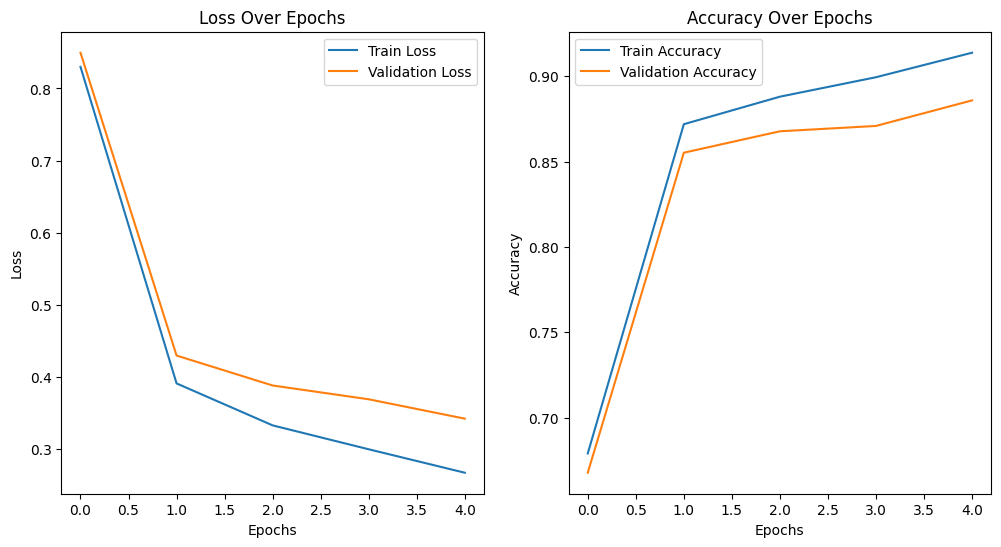

Test Loss: 0.3456, Test Accuracy: 0.8855


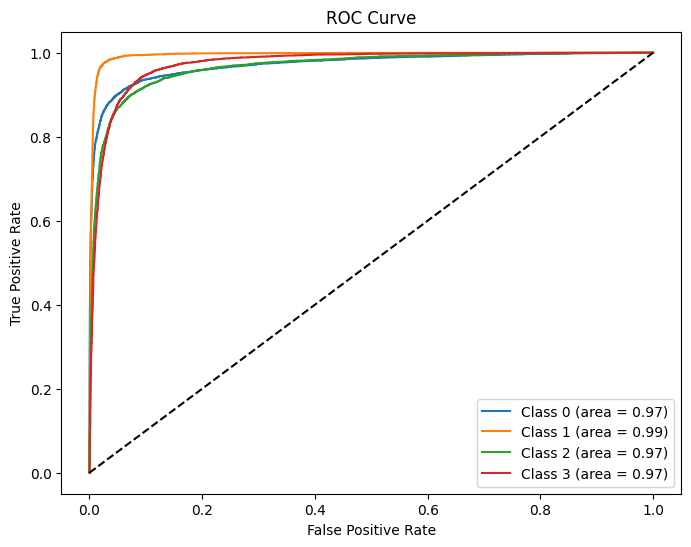

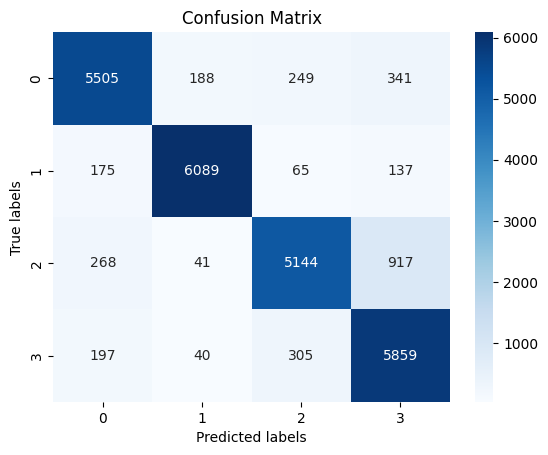

Precision: 0.8885, Recall: 0.8852, F1-Score: 0.8854


In [ ]:
#Early Stopping
model = transformer(vocab_size=len(vocab)+1, num_classes=4).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
no_imp = 0
pat = 3
best_loss = float('inf')
epochs = 5
for epoch in range(epochs):
    model.train()
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(texts)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    train_loss, train_acc, _, _, _ = evaluate(model, train_loader, criterion, device)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    if val_loss < best_loss:
        best_loss = val_loss
        no_imp = 0
    else:
        no_imp += 1
        if no_imp >= pat:
            print("Early stopping")
            break

plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)
test_loss, test_acc, test_labels, test_preds, test_probs = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

plot_roc_curve(test_labels, np.array(test_probs), num_classes=4)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

In [ ]:
torch.save(model.state_dict(), 'adarshre_dharmaac_assignment2_part_4.h5')